Structure is based on  https://github.com/prateekm08/CycleGAN-straightforward/blob/master/monetgram.ipynb

some changes were done on https://colab.research.google.com/drive/1tNzNhEbTHCXytTQL-R7SnhXITBLScxUD#scrollTo=07I67grDt8ZM

Arxiv link: https://arxiv.org/abs/1703.10593

Implementation of RelativisticGAN over DCGAN 

https://github.com/AlexiaJM/RelativisticGAN



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as Fn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import Dataset
import torchvision, torchvision.transforms

import os
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

is_google_colab = os.path.exists('./sample_data')

# Settings

In [ ]:
#settings for data to use
G_lr=0.0002  #*0.1 #Learning rates directly borrowed from the paper: 0.0002 and 0.0001
D_lr=0.0001  #*0.1
batch_size = 8
if not is_google_colab:
    batch_size = 2                  #  64

image_size = (272, 480)
data_dir = 'D:\ml\Diploma\Data'
colab_src = '/content/drive/My Drive/MachineLearning/data/'
#colab_src = '/content/drive/My Drive/MachineLearning/DataSmall/'

if is_google_colab:
  from google.colab import drive 
  drive.mount('/content/drive')
  if not os.path.exists('./data'):
    !mkdir './data'
    for zip_file in ('trainA.zip', 'trainB.zip'):
      cp_cmd = f'cp "{os.path.join(colab_src, zip_file)}" "./"'
      print(cp_cmd)
      !{cp_cmd}
    !unzip -uq "./trainA.zip" -d "./data/trainA"
    !unzip -uq "./trainB.zip" -d "./data/trainB"
  data_dir = './data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
load_net = True
load_weights = False
log_output_file_name = 'log.txt'

LOAD_PATH_weights = r'D:\ml\Diploma\ConvertNetProcess\net_weights'
LOAD_PATH_net = r'D:\ml\Diploma\ConvertNetProcess\net_weights'
SAVE_PATH_EPOCH_net = r'D:\ml\Diploma\ConvertNetProcess\Model-Epoch'
TMP_PATH_IMG = r'D:\ml\Diploma\ConvertNetProcess\tmp_images'

if is_google_colab:
  LOAD_PATH_weights = '/content/drive/My Drive/MachineLearning/Model-weights/'
  ##                                         LOAD_PATH_net = '/content/drive/My Drive/MachineLearning/Model-net/'  
  SAVE_PATH_EPOCH_net = '/content/drive/My Drive/MachineLearning/Model-Epoch/'
  LOAD_PATH_net = SAVE_PATH_EPOCH_net
  TMP_PATH_IMG = '/content/drive/My Drive/MachineLearning/tmp_images/'


for dir in (LOAD_PATH_weights, SAVE_PATH_EPOCH_net, TMP_PATH_IMG):
  if not os.path.exists(dir):
    os.mkdir(dir)
log_output_file_name  = os.path.join(SAVE_PATH_EPOCH_net, log_output_file_name)
print(f'log file {log_output_file_name}')

log file /content/drive/My Drive/MachineLearning/Model-Epoch/log.txt


In [ ]:
train_1_dir = os.path.join(data_dir, 'trainA')
train_2_dir = os.path.join(data_dir, 'trainB')

def get_file_list(dir):
  return [os.path.join(dir, i) for i in os.listdir(dir)]
imgs1_addr = get_file_list(train_1_dir)
imgs2_addr = get_file_list(train_2_dir)


In [ ]:
# создаем Custom Dataset под нашу задачу - возвращаем картинку, преобразованную с помощью заданного transform
class ImgCustomDataset(Dataset):
    def __init__(self, img_dir: str, transform = None, adj_brightness = False):

        self.image_names = get_file_list(img_dir)
        self.img_dir = img_dir
        self.transform = transform
        self.adj_brightness = adj_brightness
    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        assert isinstance(idx, int), "ImgCustomDataset: idx is not an integer: %r" % idx

        image = Image.open(self.image_names[idx])
        if self.transform:
            image = self.transform(image)
        if self.adj_brightness:
            image = torchvision.transforms.functional.adjust_contrast(image, 0.7)
            image = torchvision.transforms.functional.adjust_brightness(image, brightness_factor = 1.5)
        return image

In [ ]:
# data is transformed so no need to resize/crop
def get_transform_simple(image_size):
    return torchvision.transforms.Compose([
        # torchvision.transforms.CenterCrop(image_size),      
        # torchvision.transforms.CenterCrop(218),
        # torchvision.transforms.Resize(image_size),
        torchvision.transforms.ToTensor(),
    ])

In [ ]:
simple_transform = get_transform_simple(image_size)

train_data1 = ImgCustomDataset(train_1_dir, transform = simple_transform, adj_brightness = True)
train_data2 = ImgCustomDataset(train_2_dir, transform = simple_transform, adj_brightness = False)


torch.Size([3, 272, 480])


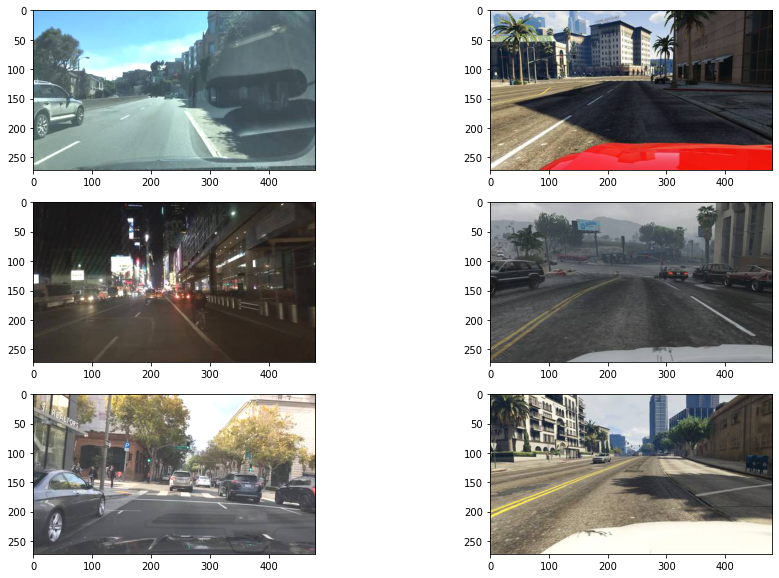

In [ ]:
def show_dataset(dataset1, dataset2):
  datasets = (dataset1, dataset2)
  K = 3
  fig, ax = plt.subplots(K, 2, figsize=(15,10))
  for i in range(K):
    for j in range(2):
      ax[i,j].imshow(datasets[j][41+i].permute(1, 2, 0))
  plt.show()

print(train_data2[0].shape)
show_dataset(train_data1, train_data2)

In [ ]:
dataloader1 = torch.utils.data.DataLoader(train_data1, batch_size=batch_size, shuffle=True) 
dataloader2 = torch.utils.data.DataLoader(train_data2, batch_size=batch_size, shuffle=True) 

In [ ]:
###########     helper functions (not for networks) #######
def print_and_log(txt):
  global log_output_file_name
  print(txt)
  log_output = open(log_output_file_name, 'a')
  log_output.write(repr(txt))
  log_output.write('\r\n')
  log_output.close()

In [ ]:
############    helper functions    #######################
def net_parameters(model):
  return f"Кол-во обучаемых параметров {sum(p.numel() for p in model.parameters() if p.requires_grad):,}"

def print_net_layers_shapes(model, X, verbose = False):
  print(f'Input shape: {X.shape}')
  print(f'Output shape: {model(X).shape}')
  print(net_parameters(model))

  for i,layer in enumerate(model.modules()):  
    layer_name = layer.__class__.__name__
    if verbose:
      print(f'{layer_name}   {layer}')
    if sum(1 for x in layer.children()) > 0: 
      print(f'Net name: {layer_name}')
      continue # skip top level Network 
    if 'Linear' in layer_name: 
      X = X.view(X.size(0), -1)
    X = layer(X)  
    print(f'{layer_name} - output shape: {X.shape}   {layer}')

# Discriminators

In [ ]:
# discriminator for whole picture (141 x 141), can be applied to 128*128 image
class discriminator_nonpatch(nn.Module):
    def __init__(self):
        super(discriminator_nonpatch, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2)
        self.bn2 = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2)
        self.bn3 = nn.BatchNorm2d(256)
        
        self.conv4 = nn.Conv2d(256, 512, kernel_size=4, stride=2)
        self.bn4 = nn.BatchNorm2d(512)
        
        self.conv5 = nn.Conv2d(512, 512, kernel_size=6, stride=1)
        
        self.head = nn.Linear(512, 1)
        
    def forward(self, input):
        x = Fn.leaky_relu(self.conv1(input), negative_slope=0.2)
        x = Fn.leaky_relu(self.bn2(self.conv2(x)), negative_slope=0.2)
        x = Fn.leaky_relu(self.bn3(self.conv3(x)), negative_slope=0.2)
        x = Fn.leaky_relu(self.bn4(self.conv4(x)), negative_slope=0.2)
        x = Fn.leaky_relu(self.conv5(x), negative_slope=0.2)
        
        x = x.view(x.size(0), -1)
        x = self.head(x)
        
        return torch.sigmoid(x)

In [ ]:
model = discriminator_nonpatch()
X = torch.rand(size=(2, 3, 141, 141)) 
print_net_layers_shapes(model, X) #X = torch.rand(size=(2, 3, 141, 141)) 
del model

Input shape: torch.Size([2, 3, 141, 141])
Output shape: torch.Size([2, 1])
Кол-во обучаемых параметров 12,196,545
Net name: discriminator_nonpatch
Conv2d - output shape: torch.Size([2, 64, 69, 69])   Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2))
Conv2d - output shape: torch.Size([2, 128, 33, 33])   Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
BatchNorm2d - output shape: torch.Size([2, 128, 33, 33])   BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Conv2d - output shape: torch.Size([2, 256, 15, 15])   Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
BatchNorm2d - output shape: torch.Size([2, 256, 15, 15])   BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Conv2d - output shape: torch.Size([2, 512, 6, 6])   Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2))
BatchNorm2d - output shape: torch.Size([2, 512, 6, 6])   BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Conv2d - output sh

In [ ]:
# discriminator (77 x 77), can be applied to (70 x 70) image
class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2)
        self.bn2 = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2)
        self.bn3 = nn.BatchNorm2d(256)
        
        self.conv4 = nn.Conv2d(256, 512, kernel_size=4, stride=2)
        self.bn4 = nn.BatchNorm2d(512)
        
        self.conv5 = nn.Conv2d(512, 512, kernel_size=2, stride=1)
        
        self.head = nn.Linear(512, 1)
        
    def forward(self, input):
        x = Fn.leaky_relu(self.conv1(input), negative_slope=0.2)
        x = Fn.leaky_relu(self.bn2(self.conv2(x)), negative_slope=0.2)
        x = Fn.leaky_relu(self.bn3(self.conv3(x)), negative_slope=0.2)
        x = Fn.leaky_relu(self.bn4(self.conv4(x)), negative_slope=0.2)
        x = Fn.leaky_relu(self.conv5(x), negative_slope=0.2)
        
        x = x.view(x.size(0), -1)
        x = self.head(x)
        
        return torch.sigmoid(x)

In [ ]:
model = discriminator()
X = torch.rand(size=(2, 3, 70, 70)) 
print_net_layers_shapes(model, X)
del model

Input shape: torch.Size([2, 3, 70, 70])
Output shape: torch.Size([2, 1])
Кол-во обучаемых параметров 3,807,937
Net name: discriminator
Conv2d - output shape: torch.Size([2, 64, 34, 34])   Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2))
Conv2d - output shape: torch.Size([2, 128, 16, 16])   Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
BatchNorm2d - output shape: torch.Size([2, 128, 16, 16])   BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Conv2d - output shape: torch.Size([2, 256, 7, 7])   Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
BatchNorm2d - output shape: torch.Size([2, 256, 7, 7])   BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Conv2d - output shape: torch.Size([2, 512, 2, 2])   Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2))
BatchNorm2d - output shape: torch.Size([2, 512, 2, 2])   BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Conv2d - output shape: torch.Size(

### discriminator2 (73 x 73) Кол-во параметров 2,936,813

In [ ]:
# discriminator (73 x 73), can be applied to (70 x 70) image              first layer is "stride=1"
class discriminator2(nn.Module):
    def __init__(self):
        super(discriminator2, self).__init__()

        self.conv0 = nn.Conv2d(3, 64, kernel_size=4, stride=1)
        self.conv1 = nn.Conv2d(64, 100, kernel_size=4, stride=2)
        self.bn1 = nn.BatchNorm2d(100)

        self.conv2 = nn.Conv2d(100, 128, kernel_size=4, stride=2)
        self.bn2 = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2)
        self.bn3 = nn.BatchNorm2d(256)
        
        self.conv4 = nn.Conv2d(256, 512, kernel_size=4, stride=2)
        self.bn4 = nn.BatchNorm2d(512)
        
        #self.conv5 = nn.Conv2d(512, 512, kernel_size=2, stride=1)
        #self.head = nn.Linear(512, 1)
        self.conv5_head = nn.Conv2d(512, 1, kernel_size=2, stride=1)

    def forward(self, input):
        x = Fn.leaky_relu(self.conv0(input), negative_slope=0.2)
        x = Fn.leaky_relu(self.bn1(self.conv1(x)), negative_slope=0.2)
        x = Fn.leaky_relu(self.bn2(self.conv2(x)), negative_slope=0.2)
        x = Fn.leaky_relu(self.bn3(self.conv3(x)), negative_slope=0.2)
        x = Fn.leaky_relu(self.bn4(self.conv4(x)), negative_slope=0.2)
        #x = Fn.leaky_relu(self.conv5(x), negative_slope=0.2)
        #x = x.view(x.size(0), -1)
        #x = self.head(x)
        #return torch.sigmoid(x)
        x = self.conv5_head(x)
        assert x.shape[1] == 1
        assert x.shape[2] == 1
        assert x.shape[3] == 1
        x = x.view(-1)
        return x

In [ ]:
# discriminator (73 x 73), can be applied to (70 x 70) image              first layer is "stride=1"
model = discriminator2()
X = torch.rand(size=(2, 3, 73, 73)) 
print_net_layers_shapes(model, X)
del model

Input shape: torch.Size([2, 3, 73, 73])
Output shape: torch.Size([2])
Кол-во обучаемых параметров 2,936,813
Net name: discriminator2
Conv2d - output shape: torch.Size([2, 64, 70, 70])   Conv2d(3, 64, kernel_size=(4, 4), stride=(1, 1))
Conv2d - output shape: torch.Size([2, 100, 34, 34])   Conv2d(64, 100, kernel_size=(4, 4), stride=(2, 2))
BatchNorm2d - output shape: torch.Size([2, 100, 34, 34])   BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Conv2d - output shape: torch.Size([2, 128, 16, 16])   Conv2d(100, 128, kernel_size=(4, 4), stride=(2, 2))
BatchNorm2d - output shape: torch.Size([2, 128, 16, 16])   BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Conv2d - output shape: torch.Size([2, 256, 7, 7])   Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
BatchNorm2d - output shape: torch.Size([2, 256, 7, 7])   BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Conv2d - output shape: torch.Siz

In [ ]:
# discriminator (73 x 73), can be applied to (70 x 70) image              first layer is "stride=1"
class discriminator3_small(nn.Module):
    def __init__(self):
        super(discriminator3_small, self).__init__()

        self.conv0 = nn.Conv2d(3, 32, kernel_size=4, stride=1)
        self.conv1 = nn.Conv2d(32, 32, kernel_size=4, stride=2)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2)
        self.bn4 = nn.BatchNorm2d(256)
        
        #self.conv5 = nn.Conv2d(512, 512, kernel_size=2, stride=1)
        #self.head = nn.Linear(512, 1)
        self.conv5_head = nn.Conv2d(256, 1, kernel_size=2, stride=1)

    def forward(self, input):
        x = Fn.leaky_relu(self.conv0(input), negative_slope=0.2)
        x = Fn.leaky_relu(self.bn1(self.conv1(x)), negative_slope=0.2)
        x = Fn.leaky_relu(self.bn2(self.conv2(x)), negative_slope=0.2)
        x = Fn.leaky_relu(self.bn3(self.conv3(x)), negative_slope=0.2)
        x = Fn.leaky_relu(self.bn4(self.conv4(x)), negative_slope=0.2)
        #x = Fn.leaky_relu(self.conv5(x), negative_slope=0.2)
        #x = x.view(x.size(0), -1)
        #x = self.head(x)
        #return torch.sigmoid(x)
        x = self.conv5_head(x)
        assert x.shape[1] == 1
        assert x.shape[2] == 1
        assert x.shape[3] == 1
        x = x.view(-1)
        return x

        

In [ ]:
# discriminator (73 x 73), can be applied to (70 x 70) image              first layer is "stride=1"
model = discriminator3_small()
X = torch.rand(size=(2, 3, 73, 73)) 
print_net_layers_shapes(model, X)
del model

Input shape: torch.Size([2, 3, 73, 73])
Output shape: torch.Size([2])
Кол-во обучаемых параметров 708,545
Net name: discriminator3_small
Conv2d - output shape: torch.Size([2, 32, 70, 70])   Conv2d(3, 32, kernel_size=(4, 4), stride=(1, 1))
Conv2d - output shape: torch.Size([2, 32, 34, 34])   Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2))
BatchNorm2d - output shape: torch.Size([2, 32, 34, 34])   BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Conv2d - output shape: torch.Size([2, 64, 16, 16])   Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
BatchNorm2d - output shape: torch.Size([2, 64, 16, 16])   BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Conv2d - output shape: torch.Size([2, 128, 7, 7])   Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
BatchNorm2d - output shape: torch.Size([2, 128, 7, 7])   BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Conv2d - output shape: torch.Size([2, 

In [ ]:
# discriminator (15 x 15)                           first layer is "stride=1"
class discriminator3(nn.Module):
    def __init__(self):
        super(discriminator3, self).__init__()

        self.conv3 = nn.Conv2d(3, 512, kernel_size=8, stride=4)
        self.bn3 = nn.BatchNorm2d(512)
        
        self.conv4 = nn.Conv2d(512, 512, kernel_size=2, stride=1)
        
        self.head = nn.Linear(512, 1)
        
    def forward(self, input):
        x = Fn.leaky_relu(self.bn3(self.conv3(input)), negative_slope=0.2)
        x = Fn.leaky_relu(self.conv4(x), negative_slope=0.2)
        
        x = x.view(x.size(0), -1)
        x = self.head(x)
        
        return torch.sigmoid(x)

In [ ]:
model = discriminator3()
X = torch.rand(size=(2, 3, 15, 15)) 
print_net_layers_shapes(model, X)
del model

Input shape: torch.Size([2, 3, 15, 15])
Output shape: torch.Size([2, 1])
Кол-во обучаемых параметров 1,149,441
Net name: discriminator3
Conv2d - output shape: torch.Size([2, 512, 2, 2])   Conv2d(3, 512, kernel_size=(8, 8), stride=(4, 4))
BatchNorm2d - output shape: torch.Size([2, 512, 2, 2])   BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Conv2d - output shape: torch.Size([2, 512, 1, 1])   Conv2d(512, 512, kernel_size=(2, 2), stride=(1, 1))
Linear - output shape: torch.Size([2, 1])   Linear(in_features=512, out_features=1, bias=True)


### discriminator_126/3,839,201

In [ ]:
class discriminator_126(nn.Module):   # todo: try this discriminator,  requires image 126, 126
    def __init__(self):
        super(discriminator_126, self).__init__()
        
        self.conv0 = nn.Conv2d(3, 32, kernel_size=4, stride=2)   
        self.conv1 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2)
        self.bn2 = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2)
        self.bn3 = nn.BatchNorm2d(256)
        
        self.conv4 = nn.Conv2d(256, 512, kernel_size=4, stride=2)
        self.bn4 = nn.BatchNorm2d(512)
        
        self.conv5 = nn.Conv2d(512, 512, kernel_size=2, stride=1)
        
        self.head = nn.Linear(512, 1)
        
    def forward(self, input):
        x = Fn.leaky_relu(self.conv0(input), negative_slope=0.2)
        x = Fn.leaky_relu(self.conv1(x), negative_slope=0.2)
        x = Fn.leaky_relu(self.bn2(self.conv2(x)), negative_slope=0.2)
        x = Fn.leaky_relu(self.bn3(self.conv3(x)), negative_slope=0.2)
        x = Fn.leaky_relu(self.bn4(self.conv4(x)), negative_slope=0.2)
        x = Fn.leaky_relu(self.conv5(x), negative_slope=0.2)
        
        x = x.view(x.size(0), -1)
        x = self.head(x)
        
        return torch.sigmoid(x)

In [ ]:
model = discriminator_126()
X = torch.rand(size=(2, 3, 126, 126)) 
print_net_layers_shapes(model, X)
del model

Input shape: torch.Size([2, 3, 126, 126])
Output shape: torch.Size([2, 1])
Кол-во обучаемых параметров 3,839,201
Net name: discriminator_126
Conv2d - output shape: torch.Size([2, 32, 62, 62])   Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2))
Conv2d - output shape: torch.Size([2, 64, 30, 30])   Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
Conv2d - output shape: torch.Size([2, 128, 14, 14])   Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
BatchNorm2d - output shape: torch.Size([2, 128, 14, 14])   BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Conv2d - output shape: torch.Size([2, 256, 6, 6])   Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
BatchNorm2d - output shape: torch.Size([2, 256, 6, 6])   BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Conv2d - output shape: torch.Size([2, 512, 2, 2])   Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2))
BatchNorm2d - output shape: torch.Size([2, 512, 2, 2])   BatchN

In [ ]:
# https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix
import functools

class NLayerDiscriminator(nn.Module):
    """Defines a PatchGAN discriminator"""

    def __init__(self, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d):
        input_nc = 3
        """Construct a PatchGAN discriminator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            ndf (int)       -- the number of filters in the last conv layer
            n_layers (int)  -- the number of conv layers in the discriminator
            norm_layer      -- normalization layer
        """
        super(NLayerDiscriminator, self).__init__()
        if type(norm_layer) == functools.partial:  # no need to use bias as BatchNorm2d has affine parameters
            use_bias = norm_layer.func == torch.nn.InstanceNorm2d
        else:
            use_bias = norm_layer == torch.nn.InstanceNorm2d

        kw = 4
        padw = 1
        sequence = [nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw), nn.LeakyReLU(0.2, True)]
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):  # gradually increase the number of filters
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw, bias=use_bias),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw, bias=use_bias),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]  # output 1 channel prediction map
        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        """Standard forward."""
        return self.model(input)


In [ ]:
# model = NLayerDiscriminator(ndf = 64, n_layers = 3)    # 31*31
model = NLayerDiscriminator(ndf = 64, n_layers = 4)    # 63*63
X = torch.rand(size=(2, 3, 63, 63)) 
print_net_layers_shapes(model, X)
#print(model(X))
del model

Input shape: torch.Size([2, 3, 63, 63])
Output shape: torch.Size([2, 1, 1, 1])
Кол-во обучаемых параметров 6,960,961
Net name: NLayerDiscriminator
Net name: Sequential
Conv2d - output shape: torch.Size([2, 64, 31, 31])   Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
LeakyReLU - output shape: torch.Size([2, 64, 31, 31])   LeakyReLU(negative_slope=0.2, inplace=True)
Conv2d - output shape: torch.Size([2, 128, 15, 15])   Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
BatchNorm2d - output shape: torch.Size([2, 128, 15, 15])   BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
LeakyReLU - output shape: torch.Size([2, 128, 15, 15])   LeakyReLU(negative_slope=0.2, inplace=True)
Conv2d - output shape: torch.Size([2, 256, 7, 7])   Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
BatchNorm2d - output shape: torch.Size([2, 256, 7, 7])   BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=Tr

### DCGAN networks (for 32*32 images from CIFAR-10)

In [ ]:
# 
# From https://github.com/AlexiaJM/RelativisticGAN/blob/master/code/GAN_losses_iter.py
# 
class Params: pass
param = Params()
param.arch = 0  # default=0      0: standard CNN  for 32x32 images from the Spectral GAN paper, 1: DCGAN with number of layers adjusted based on image size. Some options may be ignored by some architectures.
param.z_size = 64
param.spectral_G = False # type='bool', default=False, help='If True, use spectral normalization to make the generator Lipschitz (Generally only D is spectral, not G). This Will also remove batch norm in the discriminator.'
param.n_colors = 3
param.no_batch_norm_G = False # type='bool', default=False, help='If True, no batch norm in G.
param.no_batch_norm_D = False # type='bool', default=False, help='If True, no batch norm in D.
param.Tanh_GD = False  # type='bool', default=False, help='If True, tanh everywhere.'
param.n_gpu = 1 # number of GPUs to use
param.spectral = False # type='bool', default=False, help='If True, use spectral normalization to make the discriminator Lipschitz. This Will also remove batch norm in the discriminator.
param.loss_D = 7 # type=int, default=1, help='Loss of D, see code for details (1=GAN, 2=LSGAN, 3=WGAN-GP, 4=HingeGAN, 5=RSGAN, 6=RaSGAN, 7=RaLSGAN, 8=RaHingeGAN)
param.image_size = 64 # default 64
param.G_h_size = 128 # type=int, default=128, help='Number of hidden nodes in the Generator. Used only in arch=0. Too small leads to bad results, too big blows up the GPU RAM.') # DCGAN paper original value
param.D_h_size = 64 # type=int, default=128, help='Number of hidden nodes in the Discriminator. Used only in arch=0. Too small leads to bad results, too big blows up the GPU RAM.') # DCGAN paper original value
param.SELU = False # type='bool', default=False, help='Using scaled exponential linear units (SELU) which are self-normalizing instead of ReLU with BatchNorm. Used only in arch=0. This improves stability.')
param.NN_conv = True # type='bool', default=False, help="This approach minimize checkerboard artifacts during training. Used only by arch=0. Uses nearest-neighbor resized convolutions instead of strided convolutions (https://distill.pub/2016/deconv-checkerboard/ and github.com/abhiskk/fast-neural-style).")


title = 'GAN_'
if param.arch == 1:
	title = title + '_CNN_'

	class DCGAN_G(torch.nn.Module):
		def __init__(self):
			super(DCGAN_G, self).__init__()

			self.dense = torch.nn.Linear(param.z_size, 512 * 4 * 4)

			if param.spectral_G:  # False
				model = [spectral_norm(torch.nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=True))]
				model += [torch.nn.ReLU(True),
					spectral_norm(torch.nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=True))]
				model += [torch.nn.ReLU(True),
					spectral_norm(torch.nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=True))]
				model += [torch.nn.ReLU(True),
					spectral_norm(torch.nn.Conv2d(64, param.n_colors, kernel_size=3, stride=1, padding=1, bias=True)),
					torch.nn.Tanh()]
			else:
				model = [torch.nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=True)]
				if not param.no_batch_norm_G: #True
					model += [torch.nn.BatchNorm2d(256)]
				if param.Tanh_GD:  # False
					model += [torch.nn.Tanh()]
				else:
					model += [torch.nn.ReLU(True)]
				model += [torch.nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=True)]
				if not param.no_batch_norm_G:
					model += [torch.nn.BatchNorm2d(128)]
				if param.Tanh_GD:
					model += [torch.nn.Tanh()]
				else:
					model += [torch.nn.ReLU(True)]
				model += [torch.nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=True)]
				if not param.no_batch_norm_G:
					model += [torch.nn.BatchNorm2d(64)]
				if param.Tanh_GD:
					model += [torch.nn.Tanh()]
				else:
					model += [torch.nn.ReLU(True)]
				model += [torch.nn.Conv2d(64, param.n_colors, kernel_size=3, stride=1, padding=1, bias=True),
					torch.nn.Tanh()]
			self.model = torch.nn.Sequential(*model)

		def forward(self, input):
			if isinstance(input.data, torch.cuda.FloatTensor) and param.n_gpu > 1:
				output = torch.nn.parallel.data_parallel(self.model(self.dense(input.view(-1, param.z_size)).view(-1, 512, 4, 4)), input, range(param.n_gpu))
			else:
				output = self.model(self.dense(input.view(-1, param.z_size)).view(-1, 512, 4, 4))
			#print(output.size())
			return output

	class DCGAN_D(torch.nn.Module):
		def __init__(self):
			super(DCGAN_D, self).__init__()

			self.dense = torch.nn.Linear(512 * 4 * 4, 1)

			if param.spectral:
				model = [spectral_norm(torch.nn.Conv2d(param.n_colors, 64, kernel_size=3, stride=1, padding=1, bias=True)),
					torch.nn.LeakyReLU(0.1, inplace=True),
					spectral_norm(torch.nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1, bias=True)),
					torch.nn.LeakyReLU(0.1, inplace=True),

					spectral_norm(torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=True)),
					torch.nn.LeakyReLU(0.1, inplace=True),
					spectral_norm(torch.nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=1, bias=True)),
					torch.nn.LeakyReLU(0.1, inplace=True),

					spectral_norm(torch.nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=True)),
					torch.nn.LeakyReLU(0.1, inplace=True),
					spectral_norm(torch.nn.Conv2d(256, 256, kernel_size=4, stride=2, padding=1, bias=True)),
					torch.nn.LeakyReLU(0.1, inplace=True),

					spectral_norm(torch.nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=True)),
					torch.nn.LeakyReLU(0.1, inplace=True)]
			else:
				model = [torch.nn.Conv2d(param.n_colors, 64, kernel_size=3, stride=1, padding=1, bias=True)]
				if not param.no_batch_norm_D:
					model += [torch.nn.BatchNorm2d(64)]
				if param.Tanh_GD:
					model += [torch.nn.Tanh()]
				else:
					model += [torch.nn.LeakyReLU(0.1, inplace=True)]
				model += [torch.nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1, bias=True)]
				if not param.no_batch_norm_D:
					model += [torch.nn.BatchNorm2d(64)]
				if param.Tanh_GD:
					model += [torch.nn.Tanh()]
				else:
					model += [torch.nn.LeakyReLU(0.1, inplace=True)]
				model += [torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=True)]
				if not param.no_batch_norm_D:
					model += [torch.nn.BatchNorm2d(128)]
				if param.Tanh_GD:
					model += [torch.nn.Tanh()]
				else:
					model += [torch.nn.LeakyReLU(0.1, inplace=True)]
				model += [torch.nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=1, bias=True)]
				if not param.no_batch_norm_D:
					model += [torch.nn.BatchNorm2d(128)]
				if param.Tanh_GD:
					model += [torch.nn.Tanh()]
				else:
					model += [torch.nn.LeakyReLU(0.1, inplace=True)]
				model += [torch.nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=True)]
				if not param.no_batch_norm_D:
					model += [torch.nn.BatchNorm2d(256)]
				if param.Tanh_GD:
					model += [torch.nn.Tanh()]
				else:
					model += [torch.nn.LeakyReLU(0.1, inplace=True)]
				model += [torch.nn.Conv2d(256, 256, kernel_size=4, stride=2, padding=1, bias=True)]
				if not param.no_batch_norm_D:
					model += [torch.nn.BatchNorm2d(256)]
				if param.Tanh_GD:
					model += [torch.nn.Tanh()]
				else:
					model += [torch.nn.LeakyReLU(0.1, inplace=True)]
				model += [torch.nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=True)]
				if param.Tanh_GD:
					model += [torch.nn.Tanh()]
				else:
					model += [torch.nn.LeakyReLU(0.1, inplace=True)]
			self.model = torch.nn.Sequential(*model)

			self.sig = torch.nn.Sigmoid()

		def forward(self, input):
			if isinstance(input.data, torch.cuda.FloatTensor) and param.n_gpu > 1:
				output = torch.nn.parallel.data_parallel(self.dense(self.model(input).view(-1, 512 * 4 * 4)).view(-1), input, range(param.n_gpu))
			else:
				output = self.dense(self.model(input).view(-1, 512 * 4 * 4)).view(-1)
			if param.loss_D in [1]:
				output = self.sig(output)
			#print(output.size())
			return output

if param.arch == 0:
	# DCGAN generator
	class DCGAN_G(torch.nn.Module):
		def __init__(self):
			super(DCGAN_G, self).__init__()
			main = torch.nn.Sequential()

			# We need to know how many layers we will use at the beginning
			mult = param.image_size // 8

			### Start block
			# Z_size random numbers
			if param.spectral_G:
				main.add_module('Start-SpectralConvTranspose2d', torch.nn.utils.spectral_norm(torch.nn.ConvTranspose2d(param.z_size, param.G_h_size * mult, kernel_size=4, stride=1, padding=0, bias=False)))
			else:
				main.add_module('Start-ConvTranspose2d', torch.nn.ConvTranspose2d(param.z_size, param.G_h_size * mult, kernel_size=4, stride=1, padding=0, bias=False))
			if param.SELU:
				main.add_module('Start-SELU', torch.nn.SELU(inplace=True))
			else:
				if not param.no_batch_norm_G and not param.spectral_G:
					main.add_module('Start-BatchNorm2d', torch.nn.BatchNorm2d(param.G_h_size * mult))
				if param.Tanh_GD:
					main.add_module('Start-Tanh', torch.nn.Tanh())
				else:
					main.add_module('Start-ReLU', torch.nn.ReLU())
			# Size = (G_h_size * mult) x 4 x 4

			### Middle block (Done until we reach ? x image_size/2 x image_size/2)
			i = 1
			while mult > 1:
				if param.NN_conv:
					main.add_module('Middle-UpSample [%d]' % i, torch.nn.Upsample(scale_factor=2))
					if param.spectral_G:
						main.add_module('Middle-SpectralConv2d [%d]' % i, torch.nn.utils.spectral_norm(torch.nn.Conv2d(param.G_h_size * mult, param.G_h_size * (mult//2), kernel_size=3, stride=1, padding=1)))
					else:
						main.add_module('Middle-Conv2d [%d]' % i, torch.nn.Conv2d(param.G_h_size * mult, param.G_h_size * (mult//2), kernel_size=3, stride=1, padding=1))
				else:
					if param.spectral_G:
						main.add_module('Middle-SpectralConvTranspose2d [%d]' % i, torch.nn.utils.spectral_norm(torch.nn.ConvTranspose2d(param.G_h_size * mult, param.G_h_size * (mult//2), kernel_size=4, stride=2, padding=1, bias=False)))
					else:
						main.add_module('Middle-ConvTranspose2d [%d]' % i, torch.nn.ConvTranspose2d(param.G_h_size * mult, param.G_h_size * (mult//2), kernel_size=4, stride=2, padding=1, bias=False))
				if param.SELU:
					main.add_module('Middle-SELU [%d]' % i, torch.nn.SELU(inplace=True))
				else:
					if not param.no_batch_norm_G and not param.spectral_G:
						main.add_module('Middle-BatchNorm2d [%d]' % i, torch.nn.BatchNorm2d(param.G_h_size * (mult//2)))
					if param.Tanh_GD:
						main.add_module('Middle-Tanh [%d]' % i, torch.nn.Tanh())
					else:
						main.add_module('Middle-ReLU [%d]' % i, torch.nn.ReLU())
				# Size = (G_h_size * (mult/(2*i))) x 8 x 8
				mult = mult // 2
				i += 1

			### End block
			# Size = G_h_size x image_size/2 x image_size/2
			if param.NN_conv:
				main.add_module('End-UpSample', torch.nn.Upsample(scale_factor=2))
				if param.spectral_G:
					main.add_module('End-SpectralConv2d', torch.nn.utils.spectral_norm(torch.nn.Conv2d(param.G_h_size, param.n_colors, kernel_size=3, stride=1, padding=1)))
				else:
					main.add_module('End-Conv2d', torch.nn.Conv2d(param.G_h_size, param.n_colors, kernel_size=3, stride=1, padding=1))
			else:
				if param.spectral_G:
					main.add_module('End-SpectralConvTranspose2d', torch.nn.utils.spectral_norm(torch.nn.ConvTranspose2d(param.G_h_size, param.n_colors, kernel_size=4, stride=2, padding=1, bias=False)))
				else:
					main.add_module('End-ConvTranspose2d', torch.nn.ConvTranspose2d(param.G_h_size, param.n_colors, kernel_size=4, stride=2, padding=1, bias=False))
			main.add_module('End-Tanh', torch.nn.Tanh())
			# Size = n_colors x image_size x image_size
			self.main = main

		def forward(self, input):
			if isinstance(input.data, torch.cuda.FloatTensor) and param.n_gpu > 1:
				output = torch.nn.parallel.data_parallel(self.main, input, range(param.n_gpu))
			else:
				output = self.main(input)
			return output

	# DCGAN discriminator (using somewhat the reverse of the generator)
	class DCGAN_D(torch.nn.Module):
		def __init__(self):
			super(DCGAN_D, self).__init__()
			main = torch.nn.Sequential()

			### Start block
			# Size = n_colors x image_size x image_size
			if param.spectral:
				main.add_module('Start-SpectralConv2d', torch.nn.utils.spectral_norm(torch.nn.Conv2d(param.n_colors, param.D_h_size, kernel_size=4, stride=2, padding=1, bias=False)))
			else:
				main.add_module('Start-Conv2d', torch.nn.Conv2d(param.n_colors, param.D_h_size, kernel_size=4, stride=2, padding=1, bias=False))
			if param.SELU:
				main.add_module('Start-SELU', torch.nn.SELU(inplace=True))
			else:
				if param.Tanh_GD:
					main.add_module('Start-Tanh', torch.nn.Tanh())
				else:
					main.add_module('Start-LeakyReLU', torch.nn.LeakyReLU(0.2, inplace=True))
			image_size_new = param.image_size // 2
			# Size = D_h_size x image_size/2 x image_size/2

			### Middle block (Done until we reach ? x 4 x 4)
			mult = 1
			i = 0
			while image_size_new > 4:
				if param.spectral:
					main.add_module('Middle-SpectralConv2d [%d]' % i, torch.nn.utils.spectral_norm(torch.nn.Conv2d(param.D_h_size * mult, param.D_h_size * (2*mult), kernel_size=4, stride=2, padding=1, bias=False)))
				else:
					main.add_module('Middle-Conv2d [%d]' % i, torch.nn.Conv2d(param.D_h_size * mult, param.D_h_size * (2*mult), kernel_size=4, stride=2, padding=1, bias=False))
				if param.SELU:
					main.add_module('Middle-SELU [%d]' % i, torch.nn.SELU(inplace=True))
				else:
					if not param.no_batch_norm_D and not param.spectral:
						main.add_module('Middle-BatchNorm2d [%d]' % i, torch.nn.BatchNorm2d(param.D_h_size * (2*mult)))
					if param.Tanh_GD:
						main.add_module('Start-Tanh [%d]' % i, torch.nn.Tanh())
					else:
						main.add_module('Middle-LeakyReLU [%d]' % i, torch.nn.LeakyReLU(0.2, inplace=True))
				# Size = (D_h_size*(2*i)) x image_size/(2*i) x image_size/(2*i)
				image_size_new = image_size_new // 2
				mult *= 2
				i += 1

			### End block
			# Size = (D_h_size * mult) x 4 x 4
			if param.spectral:
				main.add_module('End-SpectralConv2d', torch.nn.utils.spectral_norm(torch.nn.Conv2d(param.D_h_size * mult, 1, kernel_size=4, stride=1, padding=0, bias=False)))
			else:
				main.add_module('End-Conv2d', torch.nn.Conv2d(param.D_h_size * mult, 1, kernel_size=4, stride=1, padding=0, bias=False))
			if param.loss_D in [1]:
				main.add_module('End-Sigmoid', torch.nn.Sigmoid())
			# Size = 1 x 1 x 1 (Is a real cat or not?)
			self.main = main

		def forward(self, input):
			if isinstance(input.data, torch.cuda.FloatTensor) and param.n_gpu > 1:
				output = torch.nn.parallel.data_parallel(self.main, input, range(param.n_gpu))
			else:
				output = self.main(input)
			# Convert from 1 x 1 x 1 to 1 so that we can compare to given label (cat or not?)
			return output.view(-1)

## Initialization
G = DCGAN_G()
D = DCGAN_D()

# Initialize weights
def weights_init(m):
	classname = m.__class__.__name__
	if classname.find('Conv') != -1:
		m.weight.data.normal_(0.0, 0.02)
	elif classname.find('BatchNorm') != -1:
		# Estimated variance, must be around 1
		m.weight.data.normal_(1.0, 0.02)
		# Estimated mean, must be around 0
		m.bias.data.fill_(0)
G.apply(weights_init)
D.apply(weights_init)
print("Initialized weights")
del G
del D

Initialized weights


In [ ]:
model = DCGAN_D()    # 64*64
X = torch.rand(size=(1, 3, 64, 64)) 
print(model(X).shape)
print_net_layers_shapes(model, X, verbose = True)
del model

torch.Size([1])
Input shape: torch.Size([1, 3, 64, 64])
Output shape: torch.Size([1])
Кол-во обучаемых параметров 2,765,568
DCGAN_D   DCGAN_D(
  (main): Sequential(
    (Start-Conv2d): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (Start-LeakyReLU): LeakyReLU(negative_slope=0.2, inplace=True)
    (Middle-Conv2d [0]): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (Middle-BatchNorm2d [0]): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (Middle-LeakyReLU [0]): LeakyReLU(negative_slope=0.2, inplace=True)
    (Middle-Conv2d [1]): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (Middle-BatchNorm2d [1]): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (Middle-LeakyReLU [1]): LeakyReLU(negative_slope=0.2, inplace=True)
    (Middle-Conv2d [2]): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bia

# Generators

In [ ]:
class generator1(nn.Module):         #padding concerns: reflection? What exactly is the concept behind convTranspose?
    
    def __init__(self):
        super(generator1, self).__init__()
        
        #c7s1-32
        self.r1 = nn.ReflectionPad2d(3)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=7, stride=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        #d64
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        #d128
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        #R128
        self.r4 = nn.ReflectionPad2d(1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn4 = nn.BatchNorm2d(128)
        
        self.r5 = nn.ReflectionPad2d(1)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn5 = nn.BatchNorm2d(128)
        
        #R128
        self.r6 = nn.ReflectionPad2d(1)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn6 = nn.BatchNorm2d(128)
        
        self.r7 = nn.ReflectionPad2d(1)
        self.conv7 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn7 = nn.BatchNorm2d(128)
        
        #R128
        self.r8 = nn.ReflectionPad2d(1)
        self.conv8 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn8 = nn.BatchNorm2d(128)
        
        self.r9 = nn.ReflectionPad2d(1)
        self.conv9 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn9 = nn.BatchNorm2d(128)
        
        #R128
        self.r10 = nn.ReflectionPad2d(1)
        self.conv10 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn10 = nn.BatchNorm2d(128)
        
        self.r11 = nn.ReflectionPad2d(1)
        self.conv11 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn11 = nn.BatchNorm2d(128)
        
        #R128
        self.r12 = nn.ReflectionPad2d(1)
        self.conv12 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn12 = nn.BatchNorm2d(128)
        
        self.r13 = nn.ReflectionPad2d(1)
        self.conv13 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn13 = nn.BatchNorm2d(128)
        
        #R128
        self.r14 = nn.ReflectionPad2d(1)
        self.conv14 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn14 = nn.BatchNorm2d(128)
        
        self.r15 = nn.ReflectionPad2d(1)
        self.conv15 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn15 = nn.BatchNorm2d(128)
        
        #u64
        self.uconv16 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn16 = nn.BatchNorm2d(64)
        
        #u32
        self.uconv17 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn17 = nn.BatchNorm2d(32)
        
        #c7s1-3
        self.r18 = nn.ReflectionPad2d(3)
        self.conv18 = nn.Conv2d(32, 3, kernel_size=7, stride=1)
        self.bn18 = nn.BatchNorm2d(3)
        
    def forward(self, input):
        
        #c7s1-32
        x = Fn.leaky_relu(self.bn1(self.conv1(self.r1(input))), negative_slope=0.2)
        
        #d64
        x = Fn.leaky_relu(self.bn2(self.conv2(x)), negative_slope=0.2)
        
        #d128
        x = Fn.leaky_relu(self.bn3(self.conv3(x)), negative_slope=0.2)
        
        #R128
        x1 = Fn.leaky_relu(self.bn4(self.conv4(self.r4(x))), negative_slope=0.2)
        x1 = Fn.leaky_relu(self.bn5(self.conv5(self.r5(x1))), negative_slope=0.2)
        
        x = x + x1
        
        #R128
        x1 = Fn.leaky_relu(self.bn6(self.conv6(self.r6(x))), negative_slope=0.2)
        x1 = Fn.leaky_relu(self.bn7(self.conv7(self.r7(x1))), negative_slope=0.2)
        
        x = x + x1
        
        #R128
        x1 = Fn.leaky_relu(self.bn8(self.conv8(self.r8(x))), negative_slope=0.2)
        x1 = Fn.leaky_relu(self.bn9(self.conv9(self.r9(x1))), negative_slope=0.2)
        
        x = x + x1
        
        #R128
        x1 = Fn.leaky_relu(self.bn10(self.conv10(self.r10(x))), negative_slope=0.2)
        x1 = Fn.leaky_relu(self.bn11(self.conv11(self.r11(x1))), negative_slope=0.2)
        
        x = x + x1
       
        #R128
        x1 = Fn.leaky_relu(self.bn12(self.conv12(self.r12(x))), negative_slope=0.2)
        x1 = Fn.leaky_relu(self.bn13(self.conv13(self.r13(x1))), negative_slope=0.2)
        
        x = x + x1
        
        #R128
        x1 = Fn.leaky_relu(self.bn14(self.conv14(self.r14(x))), negative_slope=0.2)
        x1 = Fn.leaky_relu(self.bn15(self.conv15(self.r15(x1))), negative_slope=0.2)
        
        x = x + x1
        
        #u64
        x = Fn.leaky_relu(self.bn16(self.uconv16(x)), negative_slope=0.2)
        
        #u32
        x = Fn.leaky_relu(self.bn17(self.uconv17(x)), negative_slope=0.2)
        
        #c7s1-3
        x = Fn.leaky_relu(self.bn18(self.conv18(self.r18(x))), negative_slope=0.2)
        
        return torch.tanh(x)

In [ ]:
import functools
def conv_norm_act(in_dim, out_dim, kernel_size, stride, padding=0,
                  norm=nn.BatchNorm2d, relu=nn.ReLU):
    return nn.Sequential(
        nn.Conv2d(in_dim, out_dim, kernel_size, stride, padding, bias=False),
        norm(out_dim),
        relu())


def dconv_norm_act(in_dim, out_dim, kernel_size, stride, padding=0,
                   output_padding=0, norm=nn.BatchNorm2d, relu=nn.ReLU):
    return nn.Sequential(
        nn.ConvTranspose2d(in_dim, out_dim, kernel_size, stride,
                           padding, output_padding, bias=False),
        norm(out_dim),
        relu())

"""
class Discriminator(nn.Module):

    def __init__(self, dim=64):
        super(Discriminator, self).__init__()

        lrelu = functools.partial(nn.LeakyReLU, negative_slope=0.2)
        conv_bn_lrelu = functools.partial(conv_norm_act, relu=lrelu)

        self.ls = nn.Sequential(nn.Conv2d(3, dim, 4, 2, 1), nn.LeakyReLU(0.2),
                                conv_bn_lrelu(dim * 1, dim * 2, 4, 2, 1),
                                conv_bn_lrelu(dim * 2, dim * 4, 4, 2, 1),
                                conv_bn_lrelu(dim * 4, dim * 8, 4, 1, (1, 2)),
                                nn.Conv2d(dim * 8, 1, 4, 1, (2, 1)))

    def forward(self, x):
        return self.ls(x)
"""

class ResiduleBlock(nn.Module):

    def __init__(self, in_dim, out_dim):
        super(ResiduleBlock, self).__init__()

        conv_bn_relu = conv_norm_act

        self.ls = nn.Sequential(nn.ReflectionPad2d(1),
                                conv_bn_relu(in_dim, out_dim, 3, 1),
                                nn.ReflectionPad2d(1),
                                nn.Conv2d(out_dim, out_dim, 3, 1),
                                nn.BatchNorm2d(out_dim))

    def forward(self, x):
        return x + self.ls(x)


class Generator(nn.Module):

    def __init__(self, dim=64):
        super(Generator, self).__init__()

        conv_bn_relu = conv_norm_act
        dconv_bn_relu = dconv_norm_act

        self.ls = nn.Sequential(nn.ReflectionPad2d(3),
                                conv_bn_relu(3, dim * 1, 7, 1),
                                conv_bn_relu(dim * 1, dim * 2, 3, 2, 1),
                                conv_bn_relu(dim * 2, dim * 4, 3, 2, 1),
                                ResiduleBlock(dim * 4, dim * 4),
                                ResiduleBlock(dim * 4, dim * 4),
                                ResiduleBlock(dim * 4, dim * 4),
                                ResiduleBlock(dim * 4, dim * 4),
                                ResiduleBlock(dim * 4, dim * 4),
                                ResiduleBlock(dim * 4, dim * 4),
                                ResiduleBlock(dim * 4, dim * 4),
                                ResiduleBlock(dim * 4, dim * 4),
                                ResiduleBlock(dim * 4, dim * 4),
                                dconv_bn_relu(dim * 4, dim * 2, 3, 2, 1, 1),
                                dconv_bn_relu(dim * 2, dim * 1, 3, 2, 1, 1),
                                nn.ReflectionPad2d(3),
                                nn.Conv2d(dim, 3, 7, 1),
                                nn.Tanh())

    def forward(self, x):
        return self.ls(x)

In [ ]:
d_out = Generator(3)
X = torch.rand(size=(6, 3, 272, 480))  
print(d_out(X).shape)
del d_out

torch.Size([6, 3, 272, 480])


In [ ]:
def weights_init_old(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)

# Initialize weights
def weights_init(m):
	classname = m.__class__.__name__
	if classname.find('Conv') != -1:
		m.weight.data.normal_(0.0, 0.02)
	elif classname.find('BatchNorm') != -1:
		# Estimated variance, must be around 1
		m.weight.data.normal_(1.0, 0.02)
		# Estimated mean, must be around 0
		m.bias.data.fill_(0)



# Pipeline parts


## Pass through discriminator

In [ ]:
import random
pr_once = True
def pass_through_discriminator_common(discriminator, image, discriminator_size, random_start_offset = 0):
    global pr_once
    image_size = (image.shape[2], image.shape[3])
    score, k = 0, 0 #Variable(torch.zeros(1)).type(dtype)
    xp = 0 # random.randrange(0, random_start_offset)
    x = xp + discriminator_size
    
    offset = [0,0]
    offset[0] = (image_size[0] - discriminator_size)//5
    offset[1] = (image_size[1] - discriminator_size)//8
    scores = []
    if pr_once:
      print()
      print(f'=== APPLY discriminator ===  of size = {discriminator_size}')  
      print(f'random_start_offset = {random_start_offset}')
    while x <= image_size[0]:
        yp = 0 # random.randint(0, random_start_offset)
        y = yp + discriminator_size
        while y <= image_size[1]:
            k += 1
            if pr_once:
                print(f'{xp}:{x}, {yp}:{y}')
            
            cur_score = discriminator(image[:, :, xp:x, yp:y])
            scores.append(cur_score)
            score += cur_score
            yp += offset[1]
            y += offset[1]
            
        xp += offset[0]
        x += offset[0]

    pr_once = False
    return (score / k, scores)

#pass_through_discriminator = functools.partial(pass_through_discriminator_common, discriminator_size = 32, random_start_offset = 4) #DCGAN_D (1)

pass_through_discriminator = functools.partial(pass_through_discriminator_common, discriminator_size = 64, random_start_offset = 4)

## Networks

In [ ]:
model = Generator(30)
print(net_parameters(model))
del model

Кол-во обучаемых параметров 2,509,623


In [ ]:
dtype = torch.FloatTensor
if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor
    
#G = Generator(3).type(dtype)
#F = Generator(3).type(dtype)
G = Generator(30).type(dtype) #12 best so far
F = Generator(30).type(dtype)
#G = generator1().type(dtype)
#F = generator1().type(dtype)

#Dg = discriminator3_small().type(dtype)  
#Df = discriminator3_small().type(dtype)  
## Initialization discriminator
Dg = DCGAN_D().type(dtype)
Df = DCGAN_D().type(dtype)
Dg.apply(weights_init)
Df.apply(weights_init)

#Dg = DCGAN_D().type(dtype)  #todo: old
#Df = DCGAN_D().type(dtype)  #todo: old
#Dg = discriminator_126().type(dtype)
#Df = discriminator_126().type(dtype)
#Dgnp = discriminator_nonpatch().type(dtype)
#Dfnp = discriminator_nonpatch().type(dtype)

G.apply(weights_init)
F.apply(weights_init)
Dg.apply(weights_init)
Df.apply(weights_init)

DCGAN_D(
  (main): Sequential(
    (Start-Conv2d): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (Start-LeakyReLU): LeakyReLU(negative_slope=0.2, inplace=True)
    (Middle-Conv2d [0]): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (Middle-BatchNorm2d [0]): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (Middle-LeakyReLU [0]): LeakyReLU(negative_slope=0.2, inplace=True)
    (Middle-Conv2d [1]): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (Middle-BatchNorm2d [1]): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (Middle-LeakyReLU [1]): LeakyReLU(negative_slope=0.2, inplace=True)
    (Middle-Conv2d [2]): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (Middle-BatchNorm2d [2]): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (Middle-Le

In [ ]:
def set_requires_grad(net, requires_grad: bool):
  for p in net.parameters():
    p.requires_grad = requires_grad

In [ ]:
if load_net and os.path.exists(LOAD_PATH_net):
  print(f'loading networks from {LOAD_PATH_net}...')
  G = torch.load(os.path.join(LOAD_PATH_net, "G.pt"))
  F = torch.load(os.path.join(LOAD_PATH_net, "F.pt"))
  Dg = torch.load(os.path.join(LOAD_PATH_net, "Dg.pt"))
  Df = torch.load(os.path.join(LOAD_PATH_net, "Df.pt"))

if load_weights and os.path.exists(LOAD_PATH_weights):
  print(f'loading weights from {LOAD_PATH_weights}...')
  G.load_state_dict(torch.load(os.path.join(LOAD_PATH_weights,"G.pt"), map_location=torch.device('cpu')))
  F.load_state_dict(torch.load(os.path.join(LOAD_PATH_weights,"F.pt"), map_location=torch.device('cpu')))
  Dg.load_state_dict(torch.load(os.path.join(LOAD_PATH_weights,"Dg.pt"), map_location=torch.device('cpu')))
  Df.load_state_dict(torch.load(os.path.join(LOAD_PATH_weights,"Df.pt"), map_location=torch.device('cpu')))

  #G.load_state_dict(torch.load(os.path.join(LOAD_PATH_weights,"G_tmp.pt")))
  #F.load_state_dict(torch.load(os.path.join(LOAD_PATH_weights,"F_tmp.pt")))
  #Dg.load_state_dict(torch.load(os.path.join(LOAD_PATH_weights,"Dg_tmp.pt")))
  #Df.load_state_dict(torch.load(os.path.join(LOAD_PATH_weights,"Df_tmp.pt")))



loading networks from /content/drive/My Drive/MachineLearning/Model-Epoch/...


## Optimizers

In [ ]:
G_lr_local = G_lr #*0.1 #Learning rates directly borrowed from the paper: 0.0002 and 0.0001
D_lr_local = D_lr #*0.1

optimizerG = functools.partial(torch.optim.Adam, lr=G_lr_local, betas=(0.5, 0.999), weight_decay=0)
optimizerD = functools.partial(torch.optim.Adam, lr=D_lr_local, betas=(0.5, 0.999), weight_decay=0)

G_optim = optimizerG(G.parameters())
F_optim = optimizerG(F.parameters())

Dg_optim = optimizerD(Dg.parameters())
Df_optim = optimizerD(Df.parameters())

# learning rate decay
G_scheduler = optim.lr_scheduler.StepLR(G_optim, step_size=50, gamma=0.99, verbose=True) #, verbose=True)
F_scheduler = optim.lr_scheduler.StepLR(F_optim, step_size=50, gamma=0.99) #, verbose=True)
Dg_scheduler = optim.lr_scheduler.StepLR(Dg_optim, step_size=50, gamma=0.99) #, verbose=True)
Df_scheduler = optim.lr_scheduler.StepLR(Df_optim, step_size=50, gamma=0.99) #, verbose=True)

Adjusting learning rate of group 0 to 2.0000e-04.


In [ ]:
%matplotlib inline
transformerToPil = torchvision.transforms.ToPILImage()
from matplotlib.pyplot import imshow

def save_tensor_as_image_to_file(tensor, img_name):
  if not os.path.exists(TMP_PATH_IMG):
    os.mkdir(TMP_PATH_IMG)
  for i,img in enumerate(tensor):
    img = transformerToPil(img.cpu())
    img.save(os.path.join(TMP_PATH_IMG, f'{i}_{img_name}.jpg'))
    break

#save_tensor_as_image_to_file(photo1_cpu, 'ddd')

In [ ]:
def gpu_scores_to_numpy(scores):
  #return torch.squeeze(scores.detach().cpu(), 1).numpy()
  return (scores.detach().cpu()).numpy()[:4]

## Loss functions

In [ ]:
bce_loss = nn.BCELoss()
BCE_stable = torch.nn.BCEWithLogitsLoss()

def generator_loss(photo_restruct, photo_real):
  loss1 = torch.mean(torch.abs(photo_restruct - photo_real))
  loss2 = 100 * torch.mean((photo_restruct - photo_real)**2)
  return  (loss1 + loss2, [loss1.item(), loss2.item()])    # loss from generator error

def generator_loss_from_discr(scores_list_real, scores_list_fake, label_real):
  scores = []
  for scores_real,scores_fake in zip(scores_list_real, scores_list_fake):
    scores_real_mean = torch.mean(scores_real).clone().detach()
    scores_fake_mean = torch.mean(scores_fake).clone().detach()
    power = 0
    scores.append(
             (
                   torch.mean((scores_real - scores_fake_mean + power*label_real) ** 2) 
                 + (torch.mean(torch.abs(scores_real - scores_fake_mean + power*label_real)))
                 + torch.mean((scores_fake - scores_real_mean + power*label_real) ** 2)
                 + (torch.mean(torch.abs(scores_fake - scores_real_mean + power*label_real)))
             )/4
    ) # 7=RaLSGAN from RelativisticGAN
  return torch.mean(torch.stack(scores))

#    + 0 * torch.mean(torch.abs(scores_fake - label_real)) \
#    + 0 * 10 * torch.mean((scores_fake - label_real)**2) \

def discriminator_loss(scores_real, scores_fake, label_real):
  scores_real_mean = torch.mean(scores_real).clone().detach()
  scores_fake_mean = torch.mean(scores_fake).clone().detach()
  return ((torch.mean((scores_real - scores_fake_mean - label_real) ** 2) 
                 + torch.mean((scores_fake - scores_real_mean + label_real) ** 2))/2)
  #loss1 = torch.mean((scores_real - torch.mean(scores_fake) - label_real) ** 2)
  #loss2 = torch.mean((scores_fake - torch.mean(scores_real) + label_real) ** 2)
  #return (loss1 + loss2)/2

  #6 return errD = (BCE_stable(scores_real - torch.mean(scores_fake), y) + BCE_stable(scores_fake - torch.mean(scores_real), y2))/2  # 6=RaSGAN from RelativisticGAN


# Main pipeline

In [ ]:
#%%time
epochs = 200
print_and_log(f"Generator: {print(net_parameters(G))}")
print_and_log(G)
print_and_log(f"Discriminator: {print(net_parameters(Dg))}")
print_and_log(Dg)

if not os.path.exists(LOAD_PATH_weights):
  os.mkdir(LOAD_PATH_weights)
if not os.path.exists(LOAD_PATH_net):
  os.mkdir(LOAD_PATH_net)

G.train()
F.train()
Dg.train()
Df.train()

set_requires_grad(G, True)
set_requires_grad(F, True)
set_requires_grad(Dg, True)
set_requires_grad(Df, True)

k = 0
def next_batch(iterator, dataloader, batch_size):
  if iterator is None:
    iterator = iter(dataloader)
  tensor = next(iterator, None)
  if (tensor is None) or (tensor.shape[0] != batch_size):
    iterator = iter(dataloader)
    tensor = next(iterator)
  return iterator, tensor

iterator1, iterator2 = None, None

for epoch in range(epochs):
    print_and_log(f'Epoch number: {epoch+1}')
    loss_dg_item,loss_g_d_item,loss_g_g_item,loss_df_item,loss_f_d_item, loss_f_g_item = 0,0,0,0,0,0

    batches_per_epoch = 200             #  # one epoch is 1000*batch_size images
    print_every_batchNo = batches_per_epoch # 1000
    for batch in range(batches_per_epoch): 
        indx = (epoch+1)*100*1000 + (batch+1)
        #indx = (batch+1)

        iterator1, photo1_cpu = next_batch(iterator1, dataloader1, batch_size)
        iterator2, photo2_cpu = next_batch(iterator2, dataloader2, batch_size)
        """
        photo1_real = X_tensor[batch * batch_size: (batch + 1) * batch_size]
        if k!= 6286:
            photo2_real = Y_tensor[k % 6287: (k + 1) % 6287]       
        else:
            photo2_real = Y_tensor[6286]
            photo2_real = photo2_real[np.newaxis, ...]
        k += 1
        """
        photo1_real = photo1_cpu.type(dtype) #  Variable(photo1_cpu).type(dtype)
        photo2_real = photo2_cpu.type(dtype) #  Variable(photo2_cpu).type(dtype)

        #Train GAN G
        
        #Train Dg
        G.eval()
        photo2_fake = G(photo1_real)        # no gradient for G
        G.train()

        Dg_optim.zero_grad()                                                             ## zero Dg
        scores_realDg, scores_list_realDg = pass_through_discriminator(Dg, photo2_real)
        scores_list_realG = [tens.clone().detach() for tens in scores_list_realDg]
        scores_fakeDg, scores_list_fakeDg = pass_through_discriminator(Dg, photo2_fake)
        
        label_fake = (torch.zeros(batch_size)).type(dtype) # [:, None]  # Variable
        label_real = (torch.ones(batch_size)).type(dtype) # [:, None]
        
        assert scores_realDg.requires_grad and scores_fakeDg.requires_grad
        loss_dg = discriminator_loss(scores_realDg, scores_fakeDg, label_real)
        loss_dg.backward()                                                               ## backward Dg
        Dg_optim.step()                                                                  ## teach Dg

        loss_dg_item += loss_dg.item()

        if (batch+1) % print_every_batchNo == 0:
            save_tensor_as_image_to_file(photo1_cpu, f'{indx}_photo1_cpu')
            save_tensor_as_image_to_file(photo2_cpu, f'{indx}_photo2_cpu')
            save_tensor_as_image_to_file(photo2_fake.clone().detach(), f'{indx}_photo1_f')
            
            #save_tensor_as_image_to_file(photo1_real.data, f'photo1_real_{indx}')

        #Train G
        G_optim.zero_grad()                                                             ## zero G and F
        F_optim.zero_grad()

        photo2_fake = G(photo1_real)                                                    ## G
        #if (batch+1) % print_every_batchNo == 0:
        #    save_tensor_as_image_to_file(photo2_fake, f'photo1_f2_{indx}')
        
        Dg.eval()
        # scores_realG, scores_list_realG = pass_through_discriminator(Dg, photo2_real)   # no gradien for Dg           use earlier calculated value to speed up
        scores_fakeG, scores_list_fakeG = pass_through_discriminator(Dg, photo2_fake)   # no gradien for Dg
        assert scores_list_fakeG[0].requires_grad
        Dg.train()
        #assert torch.sum(next(Dg.parameters()).grad).item() == 0

        photo2_rest = G(F(photo2_real))                                                 ## G and F
        if (batch+1) % print_every_batchNo == 0:
            save_tensor_as_image_to_file(photo2_rest.clone().detach(), f'{indx}_photo2_res')
        
        loss_g_d = generator_loss_from_discr(scores_list_realG, scores_list_fakeG, label_real)
        loss_g_g, loss_g_g_items = generator_loss(photo2_rest, photo2_real)

        loss_g = loss_g_d + loss_g_g
        loss_g.backward()                                                               # backward G and F here
        G_optim.step()                                                                  ## teach G
        F_optim.step()                                                                  ## teach F

        loss_g_d_item += loss_g_d.item()
        #print(f'loss_g_d.item() = {loss_g_d.item()}')
        loss_g_g_item += loss_g_g.item()
        
        #Train GAN F
        
        #Train Df
        F.eval()
        photo1_fake = F(photo2_real)
        F.train()

        if (batch+1) % print_every_batchNo == 0:
            save_tensor_as_image_to_file(photo1_fake.clone().detach(), f'{indx}_photo2_f')
        
        Df_optim.zero_grad()                                                             ## zero Df
        scores_realDf, scores_list_realDf = pass_through_discriminator(Df, photo1_real)
        scores_list_realF = [tens.clone().detach() for tens in scores_list_realDf]
        scores_fakeDf, scores_list_fakeDf = pass_through_discriminator(Df, photo1_fake)
        
        loss_df = discriminator_loss(scores_realDf, scores_fakeDf, label_real)
        loss_df.backward()                                                               ## backward Df
        Df_optim.step()                                                                  ## teach Df

        loss_df_item += loss_df.item()
        
        #Train F
        G_optim.zero_grad()                                                             ## zero G and F
        F_optim.zero_grad()
        photo1_fake = F(photo2_real)                                                    ## F
        
        #with torch.no_grad():
        Df.eval()
        #scores_realF, scores_list_realF = pass_through_discriminator(Df, photo1_real)   # no gradien for Df                   use earlier calculated value to speed up
        scores_fakeF, scores_list_fakeF = pass_through_discriminator(Df, photo1_fake)   # no gradien for Df
        Df.train()
        
        photo1_rest = F(G(photo1_real))                                                 ## G and F
        if (batch+1) % print_every_batchNo == 0:
            save_tensor_as_image_to_file(photo1_rest.clone().detach(), f'{indx}_photo1_res')

        loss_f_d = generator_loss_from_discr(scores_list_realF, scores_list_fakeF, label_real)
        loss_f_g, loss_f_g_items = generator_loss(photo1_rest, photo1_real)
        loss_f = loss_f_d + loss_f_g
        loss_f.backward()                                                               # backward G and F here
        G_optim.step()                                                                  ## teach G
        F_optim.step()                                                                  ## teach F

        loss_f_d_item += loss_f_d.item()
        #print(f'loss_f_d.item() = {loss_f_d.item()}')
        loss_f_g_item += loss_f_g.item()

        
        if (batch+1) % print_every_batchNo == 0:
          print_and_log('')
          print_and_log(f'**Batch number: {batch+1}**')
          print_and_log(f'Discriminator G loss: {loss_dg_item/print_every_batchNo}')
          print_and_log(f'Generator G loss (from discr + from generat): {loss_g_d_item/print_every_batchNo} + {loss_g_g_item/print_every_batchNo}')
          print_and_log(f'Generator G loss (from generator items example): {loss_g_g_items}')
          print_and_log(f'Discriminator F loss: {loss_df_item/print_every_batchNo}')
          print_and_log(f'Generator F loss (from discr + from generat): {loss_f_d_item/print_every_batchNo} + {loss_f_g_item/print_every_batchNo}')
          print_and_log(f'Generator F loss (from generator items example): {loss_f_g_items}')

          loss_dg_item,loss_g_d_item,loss_g_g_item,loss_df_item,loss_f_d_item, loss_f_g_item = 0,0,0,0,0,0

        if (batch+1) % print_every_batchNo == 0:
            print(f'label_real = {gpu_scores_to_numpy(label_real)}')
            print(f'label_fake = {gpu_scores_to_numpy(label_fake)}')
            print(f'scores_realDg = {gpu_scores_to_numpy(scores_realDg)}')
            print(f'scores_fakeDg = {gpu_scores_to_numpy(scores_fakeDg)}')
            print(f'scores_fakeG =  {gpu_scores_to_numpy(scores_fakeG)}')
            print(f'scores_realDf = {gpu_scores_to_numpy(scores_realDf)}')
            print(f'scores_fakeDf = {gpu_scores_to_numpy(scores_fakeDf)}')
            print(f'scores_fakeF =  {gpu_scores_to_numpy(scores_fakeF)}')

    G_scheduler.step()
    F_scheduler.step()
    Dg_scheduler.step()
    Df_scheduler.step()
    
    if True:
      print(f'saving to {SAVE_PATH_EPOCH_net}...')
      torch.save(G, os.path.join(SAVE_PATH_EPOCH_net, "G.pt"))
      torch.save(F, os.path.join(SAVE_PATH_EPOCH_net, "F.pt"))
      torch.save(Dg, os.path.join(SAVE_PATH_EPOCH_net, "Dg.pt"))
      torch.save(Df, os.path.join(SAVE_PATH_EPOCH_net, "Df.pt"))
      #torch.save(G.state_dict(), os.path.join(SAVE_PATH_EPOCH_net,"G_tmp.pt"))
      #torch.save(F.state_dict(), os.path.join(SAVE_PATH_EPOCH_net,"F_tmp.pt"))
      #torch.save(Dg.state_dict(), os.path.join(SAVE_PATH_EPOCH_net,"Dg_tmp.pt"))
      #torch.save(Df.state_dict(), os.path.join(SAVE_PATH_EPOCH_net,"Df_tmp.pt"))
      
if is_google_colab:
    from google.colab import output  
    output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')  


Кол-во обучаемых параметров 2,509,623
Generator: None
Generator(
  (ls): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Sequential(
      (0): Conv2d(3, 30, kernel_size=(7, 7), stride=(1, 1), bias=False)
      (1): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): Conv2d(30, 60, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): Conv2d(60, 120, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): ResiduleBlock(
      (ls): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Sequential(
          (0): Conv2d(120, 120, kernel_size=(3, 3), stride=(1, 1), bias=False)
          (1): BatchN

In [ ]:
from google.colab import drive
drive.flush_and_unmount
object_methods = [method_name for method_name in dir(drive)]

In [ ]:
if not os.path.exists(LOAD_PATH_net):
  os.mkdir(LOAD_PATH_net)
